In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import json

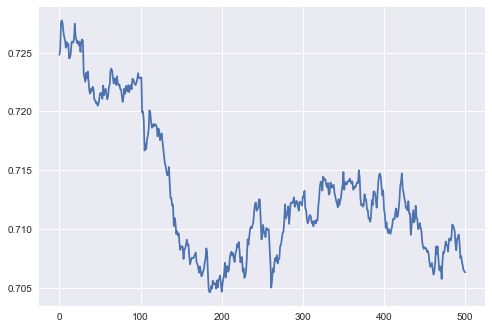

In [221]:
with open('data/data2/AUD_USD-1588780800-H1-10000.json') as f:
    data = json.load(f)
d = {r: [dic[r] for dic in data] for r in data[0]}
df = pd.DataFrame(d)
diff = list(df['O'].diff()[1:])
diff.append(np.nan)
# Label used for feature selection is when V_t=1 - V_t=0 > 0
df['d_O'] = diff
df['d_O_sign'] = df['d_O'] > 0
df_dev = df.loc[:500]
plt.plot(df_dev['O'])
plt.show()

In [375]:
import time

class MACD:
    def __init__(self, capital):
        self.capital = capital
        self.hist = pd.DataFrame()

    def act(self, observation):
        """Given an observation, return an action.
        Input:
            observation - ndarray, shape=(1, d)
        Output:
            action - int, [-1, 0, 1] for sell, nothing, buy respectively
        """
        self.hist = self.hist.append(pd.Series(observation), ignore_index=True)
        self.hist['ema26'] = self.hist[0].ewm(span=26,
                                              min_periods=26,
                                              adjust=False).mean()
        self.hist['ema12'] = self.hist[0].ewm(span=12,
                                              min_periods=12,
                                              adjust=False).mean()
        self.hist['macd'] = self.hist['ema26'] - self.hist['ema12']
        self.hist['macd_signal'] = self.hist['macd'].ewm(span=9,
                                                         min_periods=9,
                                                         adjust=False).mean()
        self.hist['diff'] = self.hist['macd'] - self.hist['macd_signal']
        self.hist['diff_lag'] = self.hist['diff'].shift(1)
        
        # action: 1 means buy, -1 means sell, 0 means do nothing
        self.hist['action'] = (np.sign(self.hist['diff']) - np.sign(self.hist['diff_lag'])) / 2
        self.hist['balance_change'] = -1 * self.hist['action'] * self.hist[0]
        
        self.hist['stock'] = self.hist['action'].cumsum()
        self.hist['balance'] = self.capital + self.hist['balance_change'].cumsum()
        
    def plot(self):
        fig, ax1 = plt.subplots()
        
        plt.title("Signals")
        ax1.plot(self.hist['macd'], label='macd')
        ax1.plot(self.hist['macd_signal'], label='macd_signal')
        ax1.set_ylabel("signals")
        plt.legend(loc='best')
        
        ax2 = ax1.twinx()
        ax2.plot(self.hist[0], 'r', label='price')
        ax2.set_ylabel("price")
        plt.show()
        
        plt.title("Balance")
        plt.plot(self.hist['balance'], '.', label='balance')
        plt.legend(loc='best')
        plt.show()
    
    def __repr__(self):
        return str(self.hist.iloc[-1])
    
    def run(self, X):
        t = []
        for i, v in enumerate(X):
            start = time.time()
            self.act(v)
            end = time.time()
            t.append(end-start)
        return t

C:\Users\notes\Anaconda3\envs\quant\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


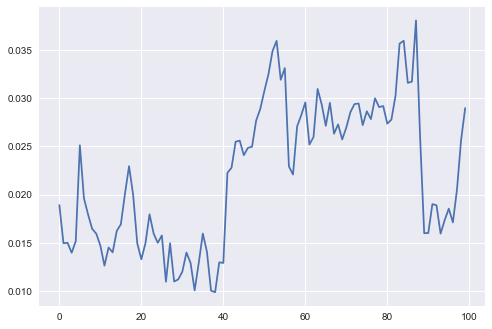

In [383]:
macd = MACD(capital=100)
t = macd.run(df['O'][:100])
plt.plot(t); plt.show()

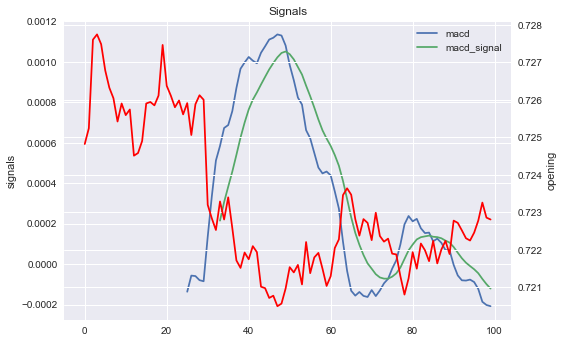

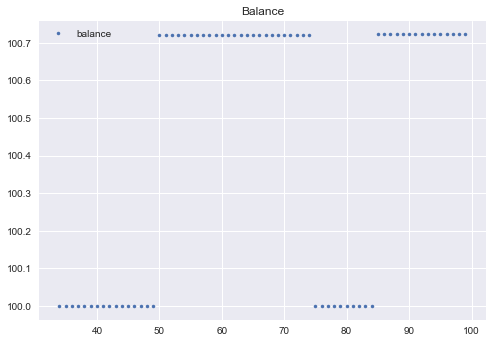

In [384]:
macd.plot()